In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate, true_positive_rate, false_positive_rate, false_negative_rate

# Load the cleaned dataset
data = pd.read_csv('cleaned_student_data2.csv')

# Define the target and features
target = 'G3'
features = data.drop(columns=[target])
sensitive_features = ['age']

# Binarize the target variable based on the mean
threshold = data[target].mean()
data['G3_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive features
data['age_bin'] = pd.cut(data['age'], bins=5, labels=False)


In [2]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, data['G3_binary'], test_size=0.2, random_state=42
)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = rf_model.predict(X_test)

# Define a function to calculate different metrics
def compute_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    return metrics

# Compute metrics for different groups
metrics = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

# Print the overall metrics
print("Overall Metrics:")
print(metrics.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups:")
print(metrics.by_group)


Overall Metrics:
{'accuracy': 0.8481012658227848, 'precision': 0.8125, 'recall': 0.9285714285714286, 'f1': 0.8666666666666667}

Metrics by Sensitive Feature Groups:
age_bin
0    {'accuracy': 0.8571428571428571, 'precision': ...
1    {'accuracy': 0.8, 'precision': 0.6666666666666...
3    {'accuracy': 0.9, 'precision': 0.8571428571428...
4    {'accuracy': 1.0, 'precision': 0.0, 'recall': ...
Name: compute_metrics, dtype: object


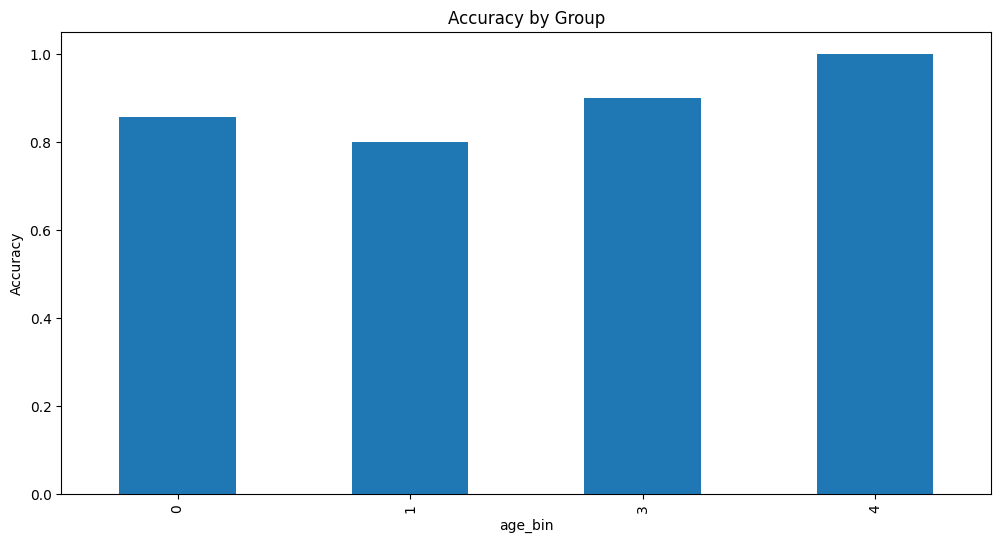

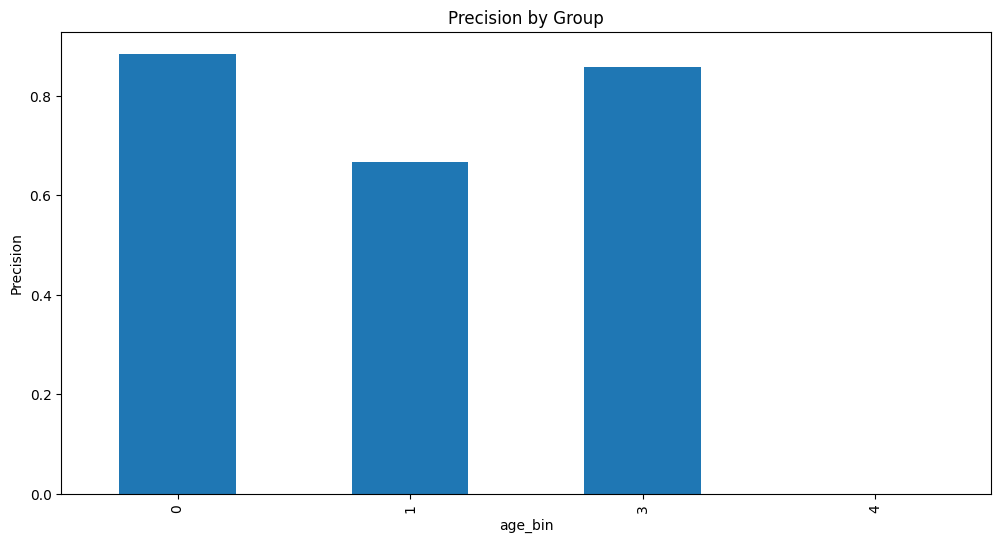

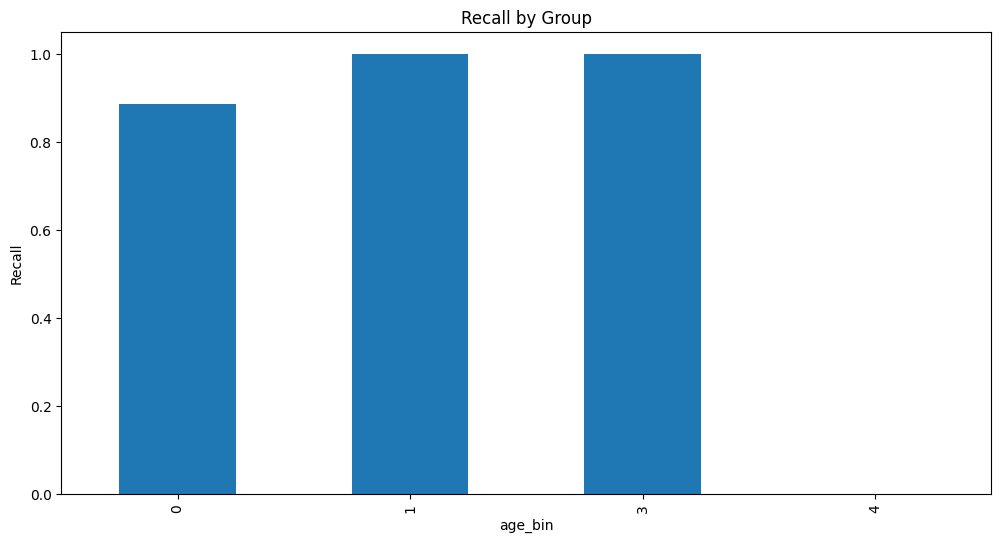

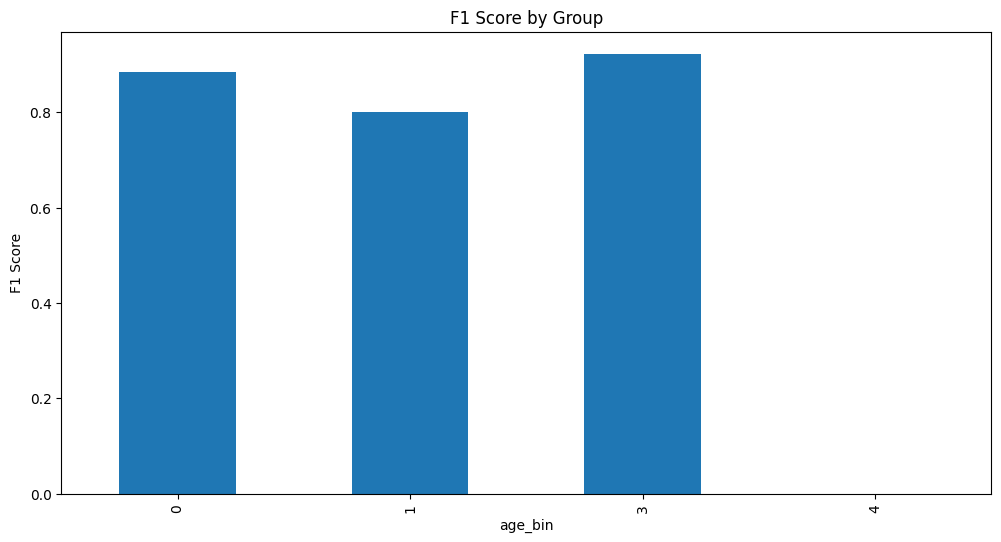

In [3]:
# Extract metrics for visualization
metrics_by_group = metrics.by_group.apply(pd.Series)
accuracy = metrics_by_group['accuracy']
precision = metrics_by_group['precision']
recall = metrics_by_group['recall']
f1 = metrics_by_group['f1']

# Plot Accuracy by Group
accuracy.plot(kind='bar', figsize=(12, 6), title='Accuracy by Group')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision by Group
precision.plot(kind='bar', figsize=(12, 6), title='Precision by Group')
plt.ylabel('Precision')
plt.show()

# Plot Recall by Group
recall.plot(kind='bar', figsize=(12, 6), title='Recall by Group')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score by Group
f1.plot(kind='bar', figsize=(12, 6), title='F1 Score by Group')
plt.ylabel('F1 Score')
plt.show()


In [4]:
# Custom Metric Functions
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn)

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tp)

def selection_rate_custom(y_pred):
    return np.mean(y_pred)

def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tn)

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp)

def false_positive_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_positive_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def selection_rate_difference(y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(selection_rate_custom(y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_omission_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_omission_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def true_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(true_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)


In [5]:
# Calculate fairness metrics
dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod = equalized_odds_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd = false_positive_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])
fnrd = false_negative_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])
srd = selection_rate_difference(y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])
for_diff = false_omission_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])
tnr_diff = true_negative_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'age_bin'])

print(f"Demographic Parity Difference: {dpd}")
print(f"Equalized Odds Difference: {eod}")
print(f"False Positive Rate Difference: {fprd}")
print(f"False Negative Rate Difference: {fnrd}")
print(f"Selection Rate Difference: {srd}")
print(f"False Omission Rate Difference: {for_diff}")
print(f"True Negative Rate Difference: {tnr_diff}")


Demographic Parity Difference: 0.7
Equalized Odds Difference: 1.0
False Positive Rate Difference: 0.3333333333333333
False Negative Rate Difference: nan
Selection Rate Difference: 0.7
False Omission Rate Difference: 0.1875
True Negative Rate Difference: 0.33333333333333337


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_12104\3047860701.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)



Additional Metrics by 'age_bin':
         accuracy  precision    recall        f1
age_bin                                         
0        0.857143   0.884615  0.884615  0.884615
1        0.800000   0.666667  1.000000  0.800000
3        0.900000   0.857143  1.000000  0.923077
4        1.000000   0.000000  0.000000  0.000000


C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: Undefi

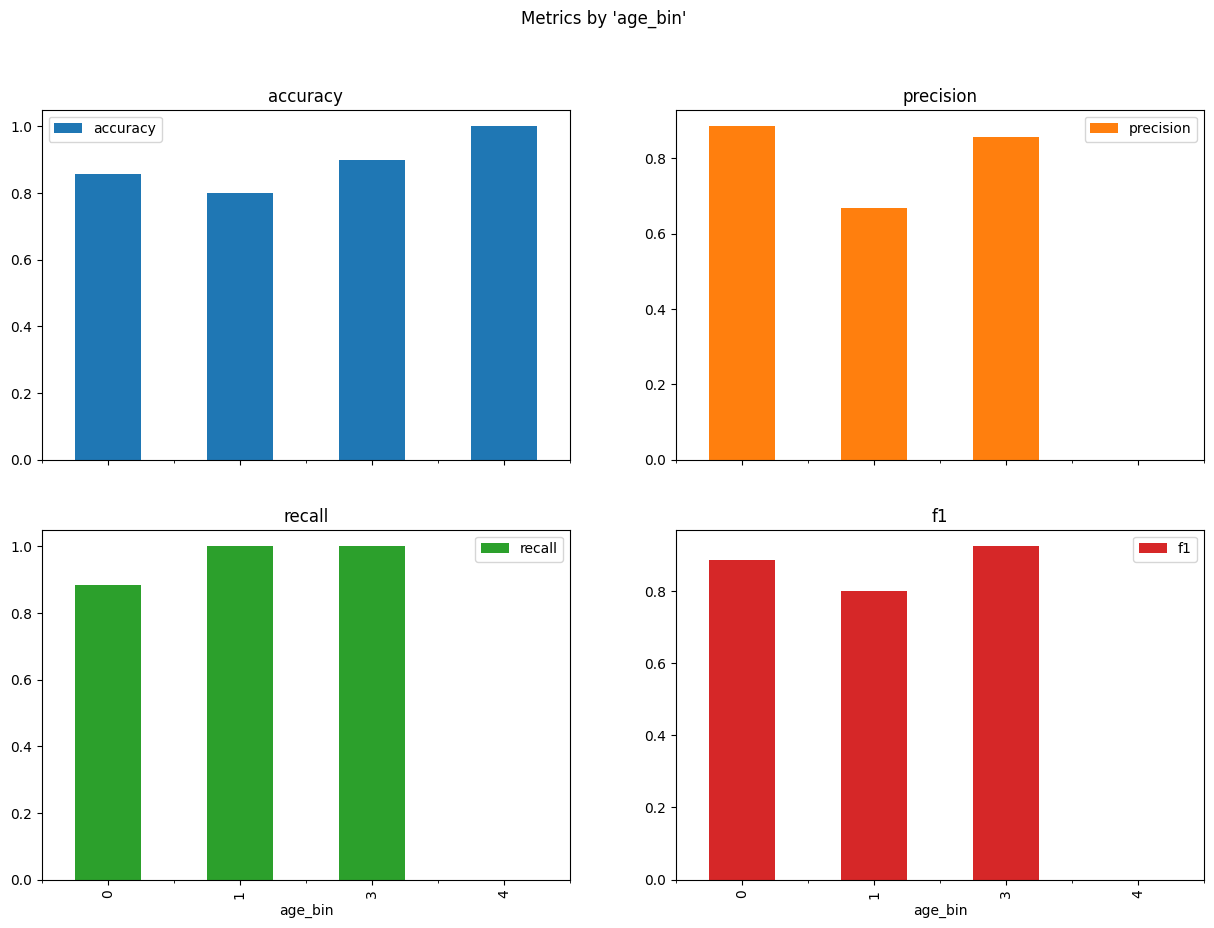


Additional Metrics by Sensitive Feature Groups:
         false_positive_rate  false_negative_rate  false_omission_rate  \
age_bin                                                                  
0                   0.187500             0.115385               0.1875   
1                   0.333333             0.000000               0.0000   
3                   0.250000             0.000000               0.0000   
4                   0.000000                  NaN               0.0000   

         true_negative_rate  
age_bin                      
0                  0.812500  
1                  0.666667  
3                  0.750000  
4                  1.000000  


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_12104\3047860701.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)


In [6]:
# Create a DataFrame for easier analysis
df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'age_bin': data.loc[X_test.index, 'age_bin']
})

# Calculate additional metrics for each subgroup
grouped_age = df.groupby('age_bin').apply(lambda x: pd.Series({
    'accuracy': accuracy_score(x['y_true'], x['y_pred']),
    'precision': precision_score(x['y_true'], x['y_pred']),
    'recall': recall_score(x['y_true'], x['y_pred']),
    'f1': f1_score(x['y_true'], x['y_pred'])
}))

print("\nAdditional Metrics by 'age_bin':")
print(grouped_age)

# Plot additional metrics by 'age_bin'
grouped_age.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Metrics by 'age_bin'")
plt.show()

# Calculate additional fairness metrics
for_custom_metrics = {
    'false_positive_rate': false_positive_rate_custom,
    'false_negative_rate': false_negative_rate_custom,
    'false_omission_rate': false_omission_rate_custom,
    'true_negative_rate': true_negative_rate_custom
}

additional_metrics = MetricFrame(
    metrics=for_custom_metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

# Print additional metrics by group
print("\nAdditional Metrics by Sensitive Feature Groups:")
print(additional_metrics.by_group)


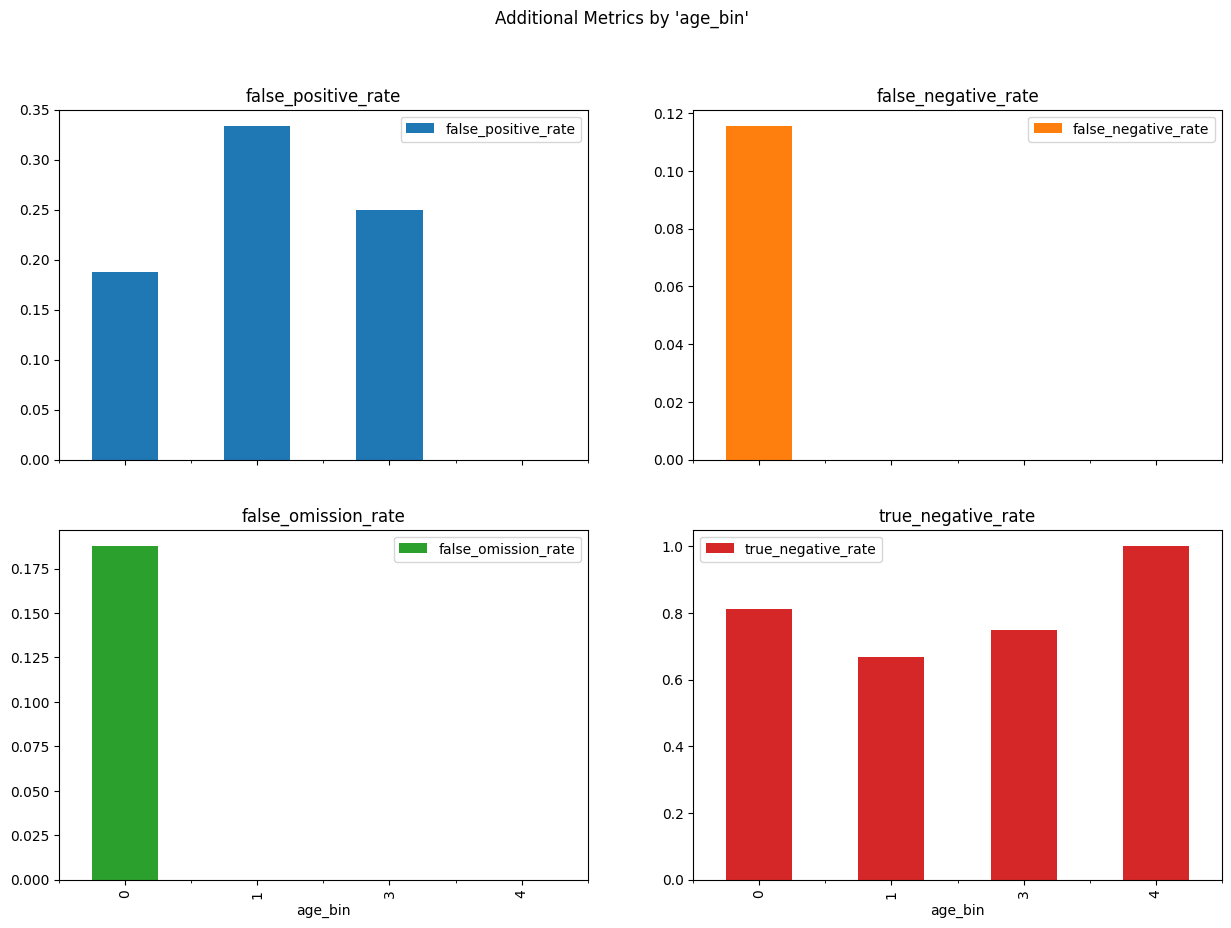


Summary of Fairness Metrics:
Demographic Parity Difference: 0.7
Equalized Odds Difference: 1.0
False Positive Rate Difference: 0.3333333333333333
False Negative Rate Difference: nan
Selection Rate Difference: 0.7
False Omission Rate Difference: 0.1875
True Negative Rate Difference: 0.33333333333333337


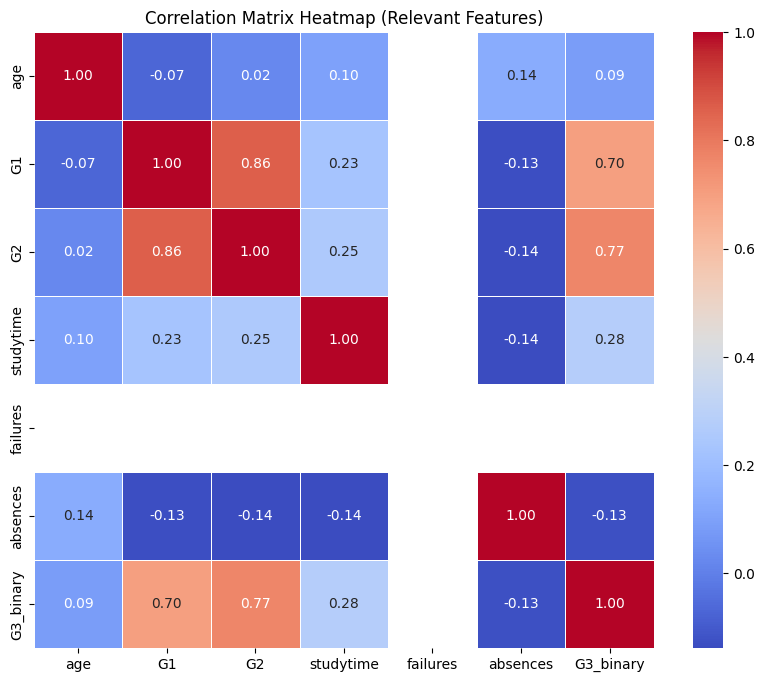

In [7]:
# Plot additional metrics
additional_metrics.by_group.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Additional Metrics by 'age_bin'")
plt.show()

# Summarize all fairness metrics
summary_metrics = {
    'Demographic Parity Difference': dpd,
    'Equalized Odds Difference': eod,
    'False Positive Rate Difference': fprd,
    'False Negative Rate Difference': fnrd,
    'Selection Rate Difference': srd,
    'False Omission Rate Difference': for_diff,
    'True Negative Rate Difference': tnr_diff
}

print("\nSummary of Fairness Metrics:")
for metric, value in summary_metrics.items():
    print(f"{metric}: {value}")

# Create heatmap of correlation matrix for relevant features
relevant_features = ['age', 'G1', 'G2', 'studytime', 'failures', 'absences', 'G3_binary']
corr_matrix = data[relevant_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Relevant Features)')
plt.show()

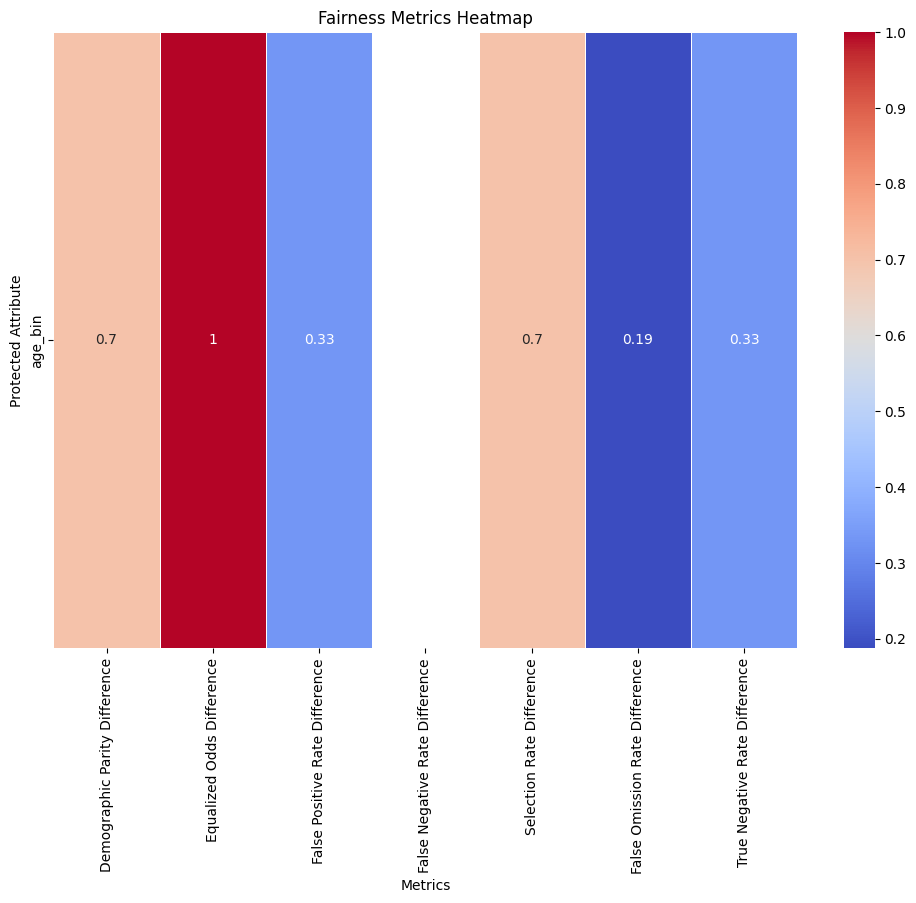

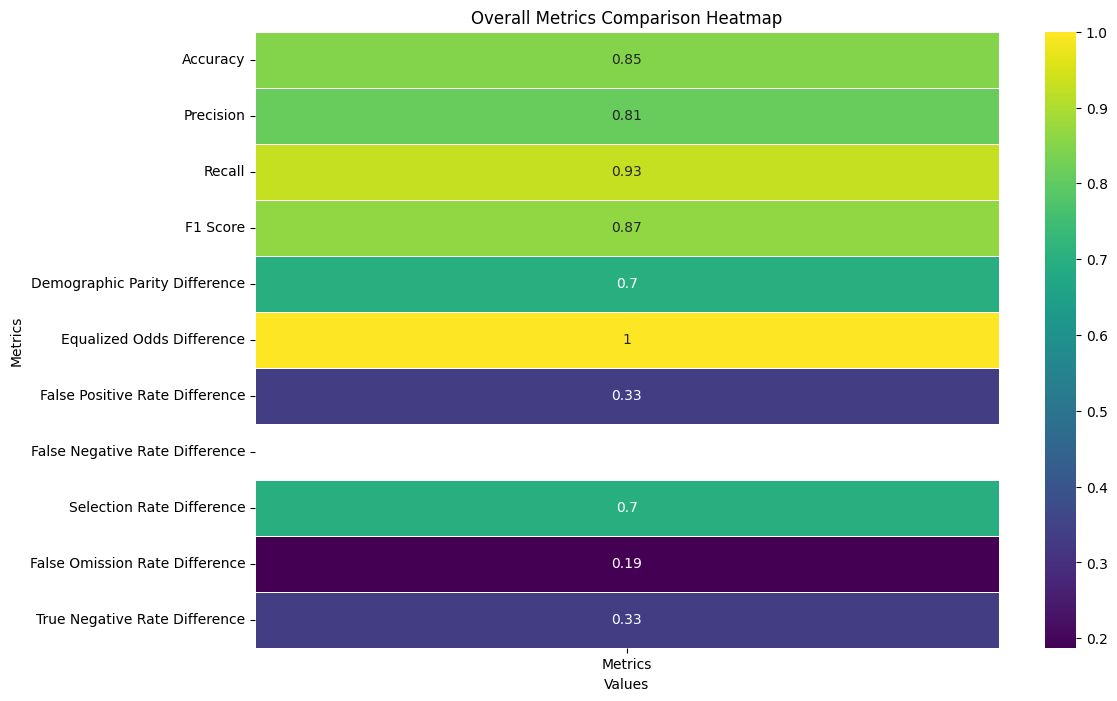

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap for fairness metrics
metrics_heatmap_data = pd.DataFrame({
    'Demographic Parity Difference': [dpd],
    'Equalized Odds Difference': [eod],
    'False Positive Rate Difference': [fprd],
    'False Negative Rate Difference': [fnrd],
    'Selection Rate Difference': [srd],
    'False Omission Rate Difference': [for_diff],
    'True Negative Rate Difference': [tnr_diff]
}, index=['age_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()

# Prepare comparison heatmap for overall metrics
comparison_heatmap_data = pd.DataFrame({
    'Accuracy': [metrics.overall['accuracy']],
    'Precision': [metrics.overall['precision']],
    'Recall': [metrics.overall['recall']],
    'F1 Score': [metrics.overall['f1']],
    'Demographic Parity Difference': [dpd],
    'Equalized Odds Difference': [eod],
    'False Positive Rate Difference': [fprd],
    'False Negative Rate Difference': [fnrd],
    'Selection Rate Difference': [srd],
    'False Omission Rate Difference': [for_diff],
    'True Negative Rate Difference': [tnr_diff]
}, index=['Metrics'])

plt.figure(figsize=(12, 8))
sns.heatmap(comparison_heatmap_data.T, annot=True, cmap='viridis', cbar=True, linewidths=0.5)
plt.title('Overall Metrics Comparison Heatmap')
plt.ylabel('Metrics')
plt.xlabel('Values')
plt.show()